# Финальная работа, специализация: **Data Analyst**
- Тема: Анализ сайта "Сберавтоподписка"
- **Исходные данные: ga_hits_clean.csv** (база событий в рамках сессии), **ga_joined.csv** (объединенный датафрейм)

**Задание**

3. Проведите проверку следующих гипотез:
- Органический трафик не отличается от платного с точки зрения CR (Conversion Rate) в целевые события.
- Трафик с мобильных устройств не отличается от трафика с десктопных устройств с точки зрения CR (Conversion Rate) в целевые события.
- Трафик из городов присутствия (Москва и область, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR (Conversion Rate) в целевые события.
4. Ответьте на вопросы продуктовой команды:
- Из каких источников (кампаний, устройств, локаций) к нам идёт самый целевой трафик (и с точки зрения объёма трафика, и с точки зрения CR)?
- Какие авто пользуются наибольшим спросом? У каких авто самый лучший показатель CR (Conversion Rate) в целевые события?
- Стоит ли нам увеличивать своё присутствие в соцсетях и давать там больше рекламы?

# 00. Импорт сторонних библиотек

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats

# 01. Чтение файлов ga_joined.csv и ga_hits_clean.csv

In [2]:
df_join = pd.read_csv('data/ga_joined.csv', low_memory=False)

In [3]:
df_join.head()

,session_id,client_id,visit_date,visit_number,utm_source,utm_medium,utm_campaign,device_category,geo_country,geo_city,advert_sn,traffic_way,city_of_present,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24 00:00:00+00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Russia,Zlatoust,0,paid,other,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14 00:00:00+00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,mobile,Russia,Moscow,1,paid,present,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28 00:00:00+00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Russia,Krasnoyarsk,0,paid,other,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29 00:00:00+00:00,1,kjsLglQLzykiRbcDiGcD,cpc,no advertising,mobile,Russia,Moscow,0,paid,present,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29 00:00:00+00:00,2,kjsLglQLzykiRbcDiGcD,cpc,no advertising,mobile,Russia,Moscow,0,paid,present,0


Описание атрибутов датафрейма из файла **ga_joined.csv:**

- session_id - ID визита;
- client_id - ID посетителя;
- visit_date - дата визита;
- visit_number - порядковый номер визита клиента;
- utm_source - канал привлечения;
- utm_medium - тип привлечения;
- utm_campaign - рекламная кампания;
- device_category - тип устройства;
- geo_country - страна;
- geo_city - город;
- advert_sn - нормализованный канал привлечения: 1 - реклама в социальных сетях, 0 - другие каналы;
- traffic_way - нормализованный тип привлечения: "free" - органический трафик, "paid" - платный (неорганический) трафик;
- city_of_present - город присутствия, где present - Москва и область, Санкт-Петербург, other - города, где нет присутствия;
- target - целевое событие: 1 - имеется целевое событие, 0 - целевое событие отсутствует.

In [4]:
df_h_clean = pd.read_csv('data/ga_hits_clean.csv')

In [5]:
df_join.head()

,session_id,client_id,visit_date,visit_number,utm_source,utm_medium,utm_campaign,device_category,geo_country,geo_city,advert_sn,traffic_way,city_of_present,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24 00:00:00+00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Russia,Zlatoust,0,paid,other,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14 00:00:00+00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,mobile,Russia,Moscow,1,paid,present,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28 00:00:00+00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Russia,Krasnoyarsk,0,paid,other,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29 00:00:00+00:00,1,kjsLglQLzykiRbcDiGcD,cpc,no advertising,mobile,Russia,Moscow,0,paid,present,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29 00:00:00+00:00,2,kjsLglQLzykiRbcDiGcD,cpc,no advertising,mobile,Russia,Moscow,0,paid,present,0


Описание атрибутов датафрейма событий из файла ga_hits_clean.csv:

- session_id - ID визита;
- hit_date - дата события;
- hit_number - порядковый номер события в рамках сессии;
- event_category - тип действия;
- target_action - целевое действие;
- auto_name - марка автомобиля;
- auto_model - модель автомобиля.

# Часть 3. Проверка гипотез

### 1. Проверка гипотезы 1: органический / платный трафик

**Нулевая гипотеза:** H0 - Органический трафик не отличается от платного с точки зрения CR в целевые события

**Альтернативная гипотеза:** H1 - Органический трафик отличается от платного с точки зрения CR в целевые события

In [6]:
# Столбец целевых событий органического трафика
organic = df_join[df_join.traffic_way == 'free'].target

# Столбец целевых событий неорганического (платного) трафика
nonorganic = df_join[df_join.traffic_way == 'paid'].target

org = len(organic)
nonorg = len(nonorganic)

print(f'Размерность датасетов с органическим и платным трафиком:')
print(f'{org} + {nonorg} = {org + nonorg}')

Размерность датасетов с органическим и платным трафиком:
515659 + 1344383 = 1860042


**1. Проверка выборок на нормальность распределения**

(array([494847.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  20812.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

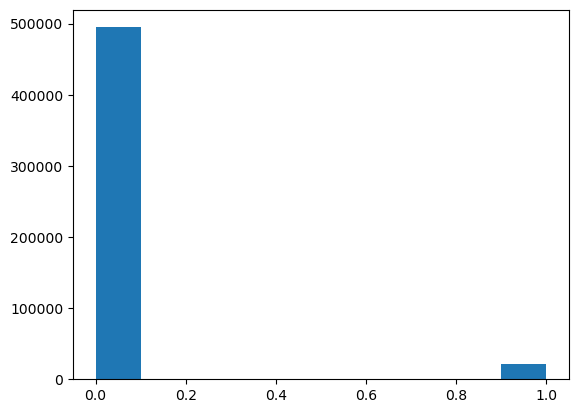

In [7]:
plt.hist(organic)

(array([1314881.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   29502.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

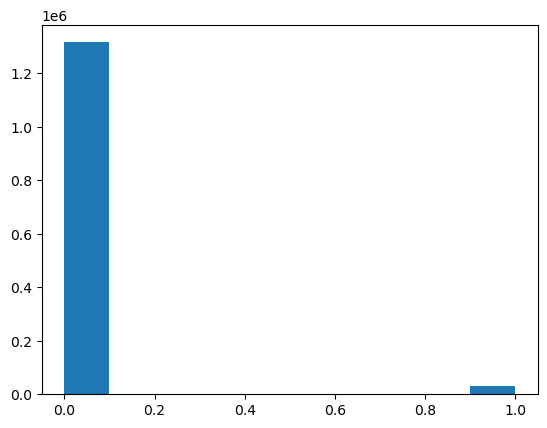

In [8]:
plt.hist(nonorganic)

Оба графики не говорят о нормальном рапределении данных выборок. Так как признак target - целевое событие имеет всего 2 значения (1 - целевое событие имеется, 0 - целевое событие отсутствует), то построение гистограмм не имеет смысла.

In [9]:
from scipy import stats
print("Тест Шапиро-Уилка на нормальность распределения данных о CR органического трафика:")
stats.shapiro(organic)

Тест Шапиро-Уилка на нормальность распределения данных о CR органического трафика:


C:\Users\Olga\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.1945204734802246, pvalue=0.0)

In [10]:
print("Тест Шапиро-Уилка на нормальность распределения данных о CR платного трафика:")
stats.shapiro(nonorganic)

Тест Шапиро-Уилка на нормальность распределения данных о CR платного трафика:


ShapiroResult(statistic=0.12785238027572632, pvalue=0.0)

В обоих выборках pvalue < 5%: распределение не является нормальным. Однако тест Шапиро-Уилка на нормальность распределения не точен из-за большого размера датасета, поэтому проверим выборки тестом Колмогорова-Смирнова

In [11]:
print('Тест Колмогорова-Смирнова на нормальность распределения:', '\n')

# Функция оценки значения pvalue теста на проверку нормальности распределения данных
def follow_normal_disribution(test):
    if test.pvalue > 0.05:
        print("Данные имеют нормальное распределение")
    else:
        print("Нулевая гипотеза о нормальном распределении данных отвергается", "\n")

print('Органический трафик:')
test_ks_1 = stats.kstest(organic, 'norm')
print(test_ks_1)
follow_normal_disribution(test_ks_1)

print('Неорганический трафик:')
test_ks_2 = stats.kstest(nonorganic, 'norm')
print(test_ks_2) 
follow_normal_disribution(test_ks_2)

Тест Колмогорова-Смирнова на нормальность распределения: 

Органический трафик:
KstestResult(statistic=0.5, pvalue=0.0)
Нулевая гипотеза о нормальном распределении данных отвергается 

Неорганический трафик:
KstestResult(statistic=0.5, pvalue=0.0)
Нулевая гипотеза о нормальном распределении данных отвергается 



**2. Выборки независимы: визиты по органическому и платному трафику сделаны разными людьми**

**3. Так как выборки не имеют нормального распределения и независимы, то для проверки гипотезы применим критерий Манна-Уитни**

In [12]:
print('Критерий Манна-Уитни: \n')

# Функция оценки значения pvalue теста на проверку гипотезы
def test_hypothesys(test):
    if test.pvalue > 0.05:
        print("Нулевая гипотеза H0 принимается")
    else:
        print("Нулевая гипотеза H0 отвергается")
              
MW_1 = stats.mannwhitneyu(organic, nonorganic)
print(MW_1)
test_hypothesys(MW_1)

Критерий Манна-Уитни: 

MannwhitneyuResult(statistic=353004760287.5, pvalue=0.0)
Нулевая гипотеза H0 отвергается


**Вывод:** Нулевая гипотеза не подтвердилась. **Органический трафик отличается от платного с точки зрения CR в целевые события.**

### 2. Проверка гипотезы 2: трафик с мобильных / десктопных устройств

**Нулевая гипотеза:** H0 - Трафик с мобильных устройств не отличается от трафика с десктопных устройств с точки зрения CR в целевые события

**Альтернативная гипотеза:** H1 - Трафик с мобильных устройств отличается от трафика с десктопных устройств с точки зрения CR в целевые события.

In [13]:
# Столбец целевых событий с мобильных устройств
mob = df_join[(df_join.device_category == 'mobile') | (df_join.device_category == 'tablet')].target

# Столбец целевых событий с десктопных устройств
desc = df_join[df_join.device_category == 'desktop'].target

m = len(mob)
d = len(desc)

print(f'Размерность датасетов с трафиком с мобильных и десктопных устройств:')
print(f'{m} + {d} = {m + d}')

Размерность датасетов с трафиком с мобильных и десктопных устройств:
1493179 + 366863 = 1860042


**1. Проверка выборок на нормальность распределения**

In [14]:
print('Тест Колмогорова-Смирнова на нормальность распределения:', '\n')

print('Трафик с мобильных устройств:')
test_ks_3 = stats.kstest(mob, 'norm')
print(test_ks_3)
follow_normal_disribution(test_ks_3)

print('Трафик с десктопных устройств:')
test_ks_4 = stats.kstest(desc, 'norm')
print(test_ks_4) 
follow_normal_disribution(test_ks_4)

Тест Колмогорова-Смирнова на нормальность распределения: 

Трафик с мобильных устройств:
KstestResult(statistic=0.5, pvalue=0.0)
Нулевая гипотеза о нормальном распределении данных отвергается 

Трафик с десктопных устройств:
KstestResult(statistic=0.5, pvalue=0.0)
Нулевая гипотеза о нормальном распределении данных отвергается 



**2. Выборки независимы: визиты c мобильных и десктопных устройств сделаны разными людьми.**

**3. Так как выборки не имеют нормального распределения и независимы, то для проверки гипотезы применим критерий Манна-Уитни**

In [15]:
print('Критерий Манна-Уитни: \n')

MW_2 = stats.mannwhitneyu(mob, desc)
print(MW_2)
test_hypothesys(MW_2)

Критерий Манна-Уитни: 

MannwhitneyuResult(statistic=272417904456.5, pvalue=7.448734524701602e-73)
Нулевая гипотеза H0 отвергается


**Вывод:** Нулевая гипотеза не подтвердилась. **Трафик с мобильных устройств отличается от трафика с десктопных устройств с точки зрения CR в целевые события.**

### 3. Проверка гипотезы 3: трафик из городов присутствия / других регионов

**Нулевая гипотеза:** H0 - Трафик из городов присутствия (Москва и область, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR в целевые события

**Альтернативная гипотеза:** H0 - Трафик из городов присутствия (Москва и область, Санкт-Петербург) отличается от трафика из иных регионов с точки зрения CR в целевые события

In [16]:
# Столбец целевых событий с городов присутствия
pres = df_join[df_join.city_of_present == 'present'].target

# Столбец целевых событий с иных регионов
oth = df_join[df_join.city_of_present == 'other'].target

pr = len(pres)
o = len(oth)

print(f'Размерность датасетов с трафиком из городов присутствия и других регионов:')
print(f'{pr} + {o} = {pr + o}')

Размерность датасетов с трафиком из городов присутствия и других регионов:
1198013 + 662029 = 1860042


**1. Проверка выборок на нормальность распределения**

In [17]:
print('Тест Колмогорова-Смирнова на нормальность распределения:', '\n')

print('Трафик из городов присутствия:')
test_ks_5 = stats.kstest(pres, 'norm')
print(test_ks_5)
follow_normal_disribution(test_ks_5)

print('Трафик из других регионов:')
test_ks_6 = stats.kstest(oth, 'norm')
print(test_ks_6) 
follow_normal_disribution(test_ks_6)

Тест Колмогорова-Смирнова на нормальность распределения: 

Трафик из городов присутствия:
KstestResult(statistic=0.5, pvalue=0.0)
Нулевая гипотеза о нормальном распределении данных отвергается 

Трафик из других регионов:
KstestResult(statistic=0.5, pvalue=0.0)
Нулевая гипотеза о нормальном распределении данных отвергается 



**2. Выборки независимы: визиты из гороов присутствия и других регионов сделаны разными людьми.**

**3. Так как выборки не имеют нормального распределения и независимы, то для проверки гипотезы применим критерий Манна-Уитни**

In [18]:
print('Критерий Манна-Уитни: \n')

MW_3 = stats.mannwhitneyu(pres, oth)
print(MW_3)
test_hypothesys(MW_3)

Критерий Манна-Уитни: 

MannwhitneyuResult(statistic=397595565067.5, pvalue=7.414326864617565e-26)
Нулевая гипотеза H0 отвергается


**Вывод:** Нулевая гипотеза не подтвердилась. **Трафик из городов присутствия отличается от трафика из других регионов с точки зрения CR в целевые события.**

# Часть 4. Data Visualization и ответы продуктовой команде

### 1. Динамика визитов и целевых событий

In [20]:
# Проверяем тип данных датафрейма
df_join.dtypes

session_id         object
client_id          object
visit_date         object
visit_number        int64
utm_source         object
utm_medium         object
utm_campaign       object
device_category    object
geo_country        object
geo_city           object
advert_sn           int64
traffic_way        object
city_of_present    object
target              int64
dtype: object

In [21]:
# Меняем тип данных столбца visit_date на дату
df_join['visit_date'] = pd.to_datetime(df_join.visit_date, utc=True)

In [22]:
# Убедимся, что данные представлены только по 2021 году
# Количество визитов
date = df_join.groupby(df_join.visit_date.dt.year)[['session_id']].count().reset_index()
date

,visit_date,session_id
0,2021,1860042


In [23]:
# Количество целевых событий
date_target = df_join.groupby(df_join.visit_date.dt.year)[['target']].sum().reset_index()
date_target

,visit_date,target
0,2021,50314


In [24]:
# Группировка визитов по дате - месяцам 2021 года
vis_date_visit = df_join.groupby(df_join.visit_date.dt.month)[['session_id']].count().reset_index()
vis_date_visit = vis_date_visit.rename(columns={'visit_date': 'month_2021', 'session_id': 'quantity_sessions'})
vis_date_visit

,month_2021,quantity_sessions
0,5,108202
1,6,166470
2,7,185244
3,8,164155
4,9,257478
5,10,281622
6,11,297769
7,12,399102


In [25]:
# Группировка целевых действий по дате визита
ta_date_visit = df_join.groupby(df_join.visit_date.dt.month)[['target']].sum().reset_index()
ta_date_visit = ta_date_visit.rename(columns={'visit_date': 'month_2021', 'target': 'quantity_targets'})
ta_date_visit

,month_2021,quantity_targets
0,5,6428
1,6,6609
2,7,4887
3,8,5498
4,9,6035
5,10,7114
6,11,6444
7,12,7299


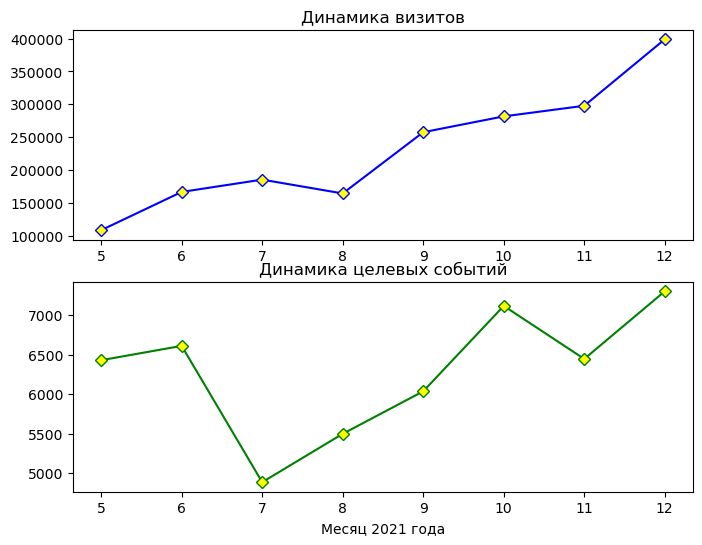

In [26]:
fig, axs = plt.subplots(nrows= 2 , ncols= 1, sharex='row', figsize=(8, 6))

axs[0].plot(vis_date_visit['month_2021'], vis_date_visit['quantity_sessions'], color='blue', marker='D', markerfacecolor='yellow')
axs[0].set_title('Динамика визитов')

axs[1].plot(ta_date_visit['month_2021'], ta_date_visit['quantity_targets'], color='green', marker='D', markerfacecolor='yellow')
axs[1].set_title('Динамика целевых событий')
axs[1].set_xlabel('Месяц 2021 года')

plt.show()

**Вывод:** Аномалия в динамике визитов и целевых событий в 7-м месяце 2021 года: при росте общего количества визитов количество целевых событий резко сократилось. По остальным месяцам положительная динамика визитов соответствует положительной динамике целевых событий.

### 2. CR (Conversion Rate) визитов в целевые события

In [27]:
print(f'CR визитов в целевые события за май-декабрь 2021 года - {round(date_target.target[0] / date.session_id[0] * 100, 1)}%')

CR визитов в целевые события за май-декабрь 2021 года - 2.7%


In [28]:
# Объединение сгруппированных датафреймов по количеству визитов и целевых событий
df_date_visit = pd.merge(left=vis_date_visit, right=ta_date_visit, on=['month_2021'], how='inner')

# Добавляем столбец conversion_rate
df_date_visit['conversion_rate'] = round(ta_date_visit.quantity_targets/vis_date_visit.quantity_sessions*100, 1)
print(f'CR (Conversion Rate) визитов в целевые события по месяцам 2021 года:')
df_date_visit

CR (Conversion Rate) визитов в целевые события по месяцам 2021 года:


,month_2021,quantity_sessions,quantity_targets,conversion_rate
0,5,108202,6428,5.9
1,6,166470,6609,4.0
2,7,185244,4887,2.6
3,8,164155,5498,3.3
4,9,257478,6035,2.3
5,10,281622,7114,2.5
6,11,297769,6444,2.2
7,12,399102,7299,1.8


**Вывод:** CR визитов в целевые события падает от мая к декабрю 2021 года, т.е. количество визитов растет более быстрыми темпами, чем количество целевых событий.

### 3. Каналы привлечения

In [29]:
# Группировка количества визитов по каналам привлечения
vis_source = df_join.groupby(['utm_source'], as_index=False)[['session_id']].count()
vis_source = vis_source.rename(columns={'session_id': 'quant'})
vis_source = vis_source.sort_values(by=['quant'], ascending=False).reset_index(drop=True)
vis_source['q_percent'] = round((vis_source['quant'] / df_join['session_id'].count() * 100), 1)

print(f'Топ-7 из {df_join.utm_source.describe()[1]} каналов привлекли {round(sum(vis_source.q_percent[:7]), 1)} % визитов:')
vis_source[:7]

Топ-7 из 293 каналов привлекли 86.2 % визитов:


,utm_source,quant,q_percent
0,ZpYIoDJMcFzVoPFsHGJL,578387,31.1
1,fDLlAcSmythWSCVMvqvL,300575,16.2
2,kjsLglQLzykiRbcDiGcD,266354,14.3
3,MvfHsxITijuriZxsqZqt,186199,10.0
4,BHcvLfOaCWvWTykYqHVe,116320,6.3
5,bByPQxmDaMXgpHeypKSM,102287,5.5
6,QxAxdyPLuQMEcrdZWdWb,51415,2.8


In [30]:
# Группировка целевых событий по каналам привлечения
ta_source = df_join.groupby(['utm_source'], as_index=False)[['target']].sum()
ta_source = ta_source.sort_values(by=['target'], ascending=False).reset_index(drop=True)
ta_source['t_percent'] = round((ta_source['target'] / df_join['target'].sum() * 100), 1)

print(f'Топ-7 из {df_join.utm_source.describe()[1]} каналов привлекли {round(sum(ta_source.t_percent[:7]), 1)}% целевых событий:')
ta_source[:7]

Топ-7 из 293 каналов привлекли 92.0% целевых событий:


,utm_source,target,t_percent
0,ZpYIoDJMcFzVoPFsHGJL,16003,31.8
1,fDLlAcSmythWSCVMvqvL,10531,20.9
2,kjsLglQLzykiRbcDiGcD,6293,12.5
3,bByPQxmDaMXgpHeypKSM,5557,11.0
4,BHcvLfOaCWvWTykYqHVe,3882,7.7
5,MvfHsxITijuriZxsqZqt,2249,4.5
6,aXQzDWsJuGXeBXexNHjc,1827,3.6


In [31]:
# Объединение сгруппированных датафреймов по количеству визитов и целевым событиям
df_source = pd.merge(left=vis_source, right=ta_source, on=['utm_source'], how='inner')

df_source['conversion_rate'] = round((df_source['target'] / df_source['quant'] * 100), 1)

# Сортировка по количеству целевых событий
df_source = df_source.sort_values(by=['target'], ascending=False).reset_index(drop=True)

print(f'Топ-7 из {df_join.utm_source.describe()[1]} каналов по количеству целевых событий - target:')
df_source[:7]

Топ-7 из 293 каналов по количеству целевых событий - target:


,utm_source,quant,q_percent,target,t_percent,conversion_rate
0,ZpYIoDJMcFzVoPFsHGJL,578387,31.1,16003,31.8,2.8
1,fDLlAcSmythWSCVMvqvL,300575,16.2,10531,20.9,3.5
2,kjsLglQLzykiRbcDiGcD,266354,14.3,6293,12.5,2.4
3,bByPQxmDaMXgpHeypKSM,102287,5.5,5557,11.0,5.4
4,BHcvLfOaCWvWTykYqHVe,116320,6.3,3882,7.7,3.3
5,MvfHsxITijuriZxsqZqt,186199,10.0,2249,4.5,1.2
6,aXQzDWsJuGXeBXexNHjc,31152,1.7,1827,3.6,5.9


In [32]:
# Сортировка по conversion_rate
df_source_cr = df_source.sort_values(by=['conversion_rate'], ascending=False).reset_index(drop=True)

print(f'Топ-7 из {df_join.utm_source.describe()[1]} каналов привлечения по уровню CR:')
df_source_cr[:7]

Топ-7 из 293 каналов привлечения по уровню CR:


,utm_source,quant,q_percent,target,t_percent,conversion_rate
0,YpBKcihLLfFjWuxOLfvW,1,0.0,1,0.0,100.0
1,fJCYsujgSxIHFbOmgDdN,8,0.0,7,0.0,87.5
2,XzfzEBYZWgSDtJNXOadn,2,0.0,1,0.0,50.0
3,CqeIpFwJscTsZoYXdHsP,2,0.0,1,0.0,50.0
4,yxJKymlSGVuKIPTxbysx,3,0.0,1,0.0,33.3
5,LIWKeifdTCbuNeniIUqm,57,0.0,17,0.0,29.8
6,JcVHXwVSrnfIuOMMEkrJ,4,0.0,1,0.0,25.0


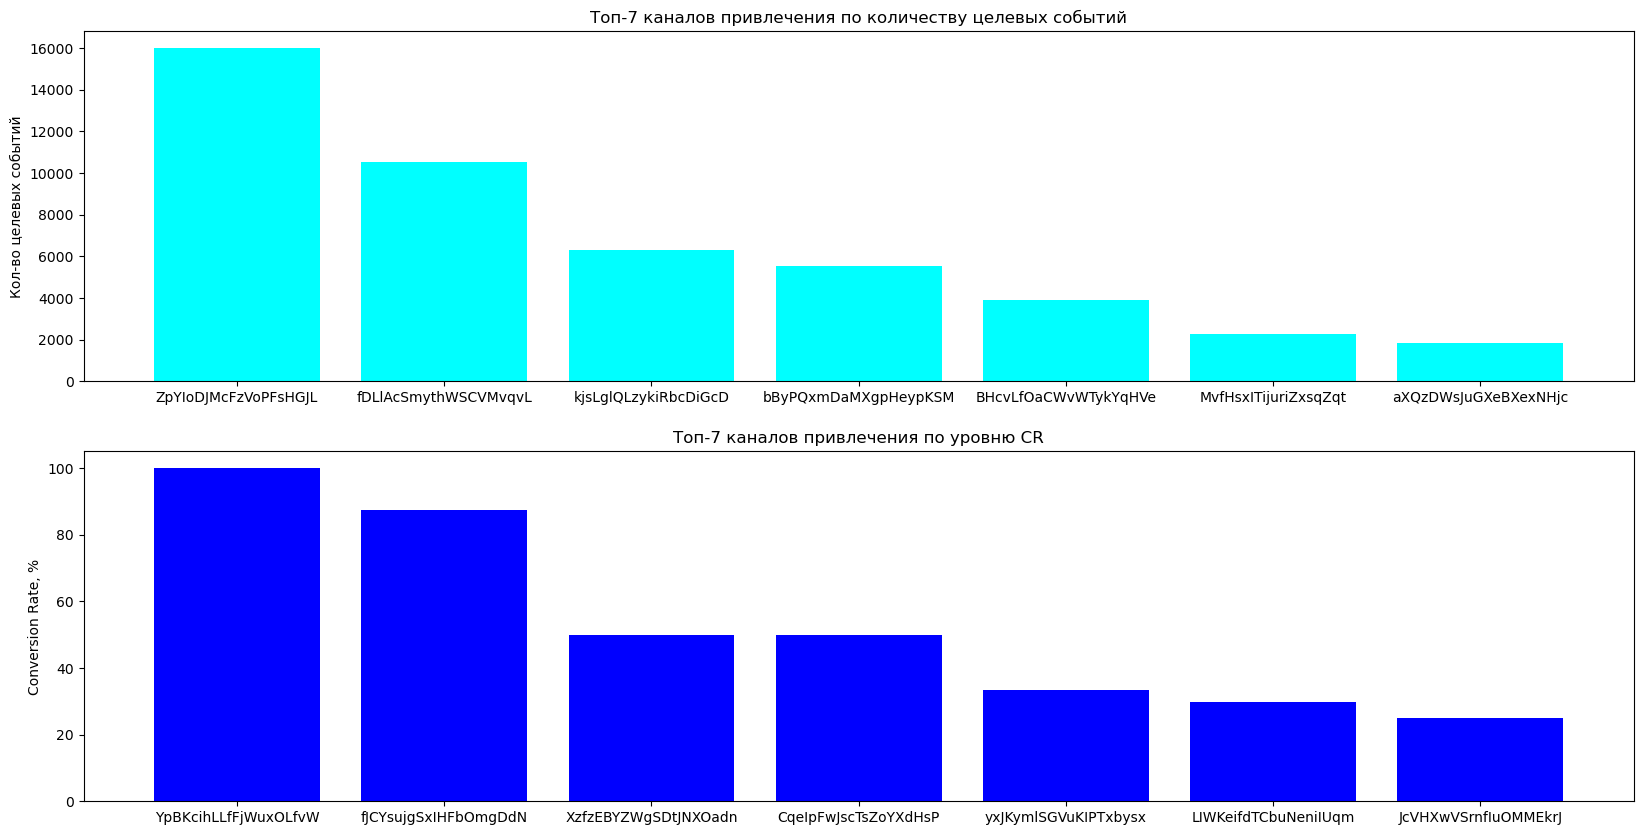

In [33]:
fig, axs = plt.subplots(nrows= 2 , ncols= 1, sharex='row', figsize=(20, 10))

axs[0].bar(df_source['utm_source'][:7], df_source['target'][:7], color=['aqua'])
axs[0].set_title('Топ-7 каналов привлечения по количеству целевых событий')
axs[0].set_ylabel('Кол-во целевых событий')

axs[1].bar(df_source_cr['utm_source'][:7], df_source_cr['conversion_rate'][:7], color=['blue'])
axs[1].set_title('Топ-7 каналов привлечения по уровню CR')
axs[1].set_ylabel('Conversion Rate, %')

plt.show()

### 4. Реклама в соцсетях

In [34]:
# Группировка каналов привлечения по количеству визитов
vis_advert = df_join.groupby(['advert_sn'], as_index=False)[['session_id']].count()
vis_advert = vis_advert.rename(columns={'session_id': 'quant'})
vis_advert['percent'] = round((vis_advert['quant'] / df_join['session_id'].count() * 100), 1)
print(f'Количество визитов: 1 - из рекламы в соцсетях; 0 - из прочих источников')
vis_advert

Количество визитов: 1 - из рекламы в соцсетях; 0 - из прочих источников


,advert_sn,quant,percent
0,0,1585815,85.3
1,1,274227,14.7


In [35]:
# Группировка целевых событий по каналам привлечения
ta_advert = df_join.groupby(['advert_sn'], as_index=False)[['target']].sum()
ta_advert['percent'] = round((ta_advert['target'] / df_join['target'].sum() * 100), 1)
print(f'Количество целевых событий: 1 - из рекламы в соцсетях; 0 - из прочих источников')
ta_advert

Количество целевых событий: 1 - из рекламы в соцсетях; 0 - из прочих источников


,advert_sn,target,percent
0,0,46293,92.0
1,1,4021,8.0


In [36]:
print(f'Реклама в социальных сетях привлекла {vis_advert.percent[1]}% визитов и {ta_advert.percent[1]}% целевых событий.')
print(f'CR рекламы в социальных сетях в целевые события - {round(ta_advert.target[1] / vis_advert.quant[1] *100, 1)}%')

Реклама в социальных сетях привлекла 14.7% визитов и 8.0% целевых событий.
CR рекламы в социальных сетях в целевые события - 1.5%


**Вывод:** Увеличивать присутствие в соцсетях и давать больше рекламы не стоит.

### 5. Рекламная кампания

In [37]:
# Группировка рекламных кампаний по количеству визитов
vis_camp = df_join.groupby(['utm_campaign'], as_index=False)[['session_id']].count()
vis_camp = vis_camp.rename(columns={'session_id': 'quant'})
vis_camp = vis_camp.sort_values(by=['quant'], ascending=False).reset_index(drop=True)

vis_camp['q_percent'] = round((vis_camp['quant'] / df_join['session_id'].count() * 100), 1)

print(f'Топ-9 из {df_join.utm_campaign.describe()[1]} рекламных кампаний привлекли {round(sum(vis_camp.q_percent[:10]), 1)}% визитов.')
print(f'Без рекламной кампании (значение атрибута "no advertising") совершено {vis_camp["q_percent"].loc[3]}% визитов')
vis_camp[:10]

Топ-9 из 413 рекламных кампаний привлекли 80.9% визитов.
Без рекламной кампании (значение атрибута "no advertising") совершено 11.8% визитов


,utm_campaign,quant,q_percent
0,LTuZkdKfxRGVceoWkVyg,463481,24.9
1,LEoPHuyFvzoNfnzGgfcd,324044,17.4
2,FTjNLDyTrXaWYgZymFkV,247360,13.3
3,no advertising,219603,11.8
4,gecBYcKZCPMcVYdSSzKP,134042,7.2
5,TmThBvoCcwkCZZUWACYq,26597,1.4
6,XHNUiSKKGTEpSAlaVMFQ,24524,1.3
7,okTXSMadDkjvntEHzIjp,24511,1.3
8,SgIUDYUKnyWHVowUOqid,22841,1.2
9,sbJRYgVfvcnqKJNDDYIr,20188,1.1


In [38]:
# Группировка рекламных кампаний по целевым событиям 
ta_camp = df_join.groupby(['utm_campaign'], as_index=False)[['target']].sum()
ta_camp = ta_camp.sort_values(by=['target'], ascending=False).reset_index(drop=True)

ta_camp['t_percent'] = round((ta_camp['target'] / df_join['target'].sum() * 100), 1)

print(f'Топ-9 из {df_join.utm_campaign.describe()[1]} рекламных кампаний привлекли {round(sum(ta_camp.t_percent), 1)}% целевых событий')
print(f'Без рекламной кампании (значение атрибута "no advertising") совершено {ta_camp["t_percent"].loc[2]}% визитов')
ta_camp[:10]

Топ-9 из 413 рекламных кампаний привлекли 98.5% целевых событий
Без рекламной кампании (значение атрибута "no advertising") совершено 14.3% визитов


,utm_campaign,target,t_percent
0,LTuZkdKfxRGVceoWkVyg,19006,37.8
1,LEoPHuyFvzoNfnzGgfcd,9348,18.6
2,no advertising,7174,14.3
3,gecBYcKZCPMcVYdSSzKP,4545,9.0
4,FTjNLDyTrXaWYgZymFkV,2447,4.9
5,sbJRYgVfvcnqKJNDDYIr,575,1.1
6,XHNUiSKKGTEpSAlaVMFQ,401,0.8
7,SgIUDYUKnyWHVowUOqid,373,0.7
8,LwJZxKuWmvOhPsaCeRjG,285,0.6
9,zxoiLxhuSIFrCeTLQVWZ,270,0.5


In [39]:
# Объединение сгруппированных датафреймов по количеству визитов и целевым событиям
df_camp = pd.merge(left=vis_camp, right=ta_camp, on=['utm_campaign'], how='inner')

df_camp['conversion_rate'] = round((df_camp['target'] / df_camp['quant'] * 100), 1)

# Сортировка по количеству целевых событий
df_camp = df_camp.sort_values(by=['target'], ascending=False).reset_index(drop=True)

print(f'Топ-9 из {df_join.utm_campaign.describe()[1]} рекламных кампаний по количеству целевых событий - target:')
df_camp[:10]

Топ-9 из 413 рекламных кампаний по количеству целевых событий - target:


,utm_campaign,quant,q_percent,target,t_percent,conversion_rate
0,LTuZkdKfxRGVceoWkVyg,463481,24.9,19006,37.8,4.1
1,LEoPHuyFvzoNfnzGgfcd,324044,17.4,9348,18.6,2.9
2,no advertising,219603,11.8,7174,14.3,3.3
3,gecBYcKZCPMcVYdSSzKP,134042,7.2,4545,9.0,3.4
4,FTjNLDyTrXaWYgZymFkV,247360,13.3,2447,4.9,1.0
5,sbJRYgVfvcnqKJNDDYIr,20188,1.1,575,1.1,2.8
6,XHNUiSKKGTEpSAlaVMFQ,24524,1.3,401,0.8,1.6
7,SgIUDYUKnyWHVowUOqid,22841,1.2,373,0.7,1.6
8,LwJZxKuWmvOhPsaCeRjG,17615,0.9,285,0.6,1.6
9,zxoiLxhuSIFrCeTLQVWZ,12370,0.7,270,0.5,2.2


In [40]:
# Сортировка по conversion_rate
df_camp_cr = df_camp.sort_values(by=['conversion_rate'], ascending=False).reset_index(drop=True)

print(f'Топ-9 из {df_join.utm_campaign.describe()[1]} рекламных кампаний по уровню CR:')
df_camp_cr[:10]

Топ-9 из 413 рекламных кампаний по уровню CR:


,utm_campaign,quant,q_percent,target,t_percent,conversion_rate
0,JkhCpeDGCtTwhwqWLywv,1,0.0,1,0.0,100.0
1,MHdHrBKQwbDaRalwnlJq,1,0.0,1,0.0,100.0
2,IRKNegNgOUQLwudzMElF,8,0.0,7,0.0,87.5
3,SbYAsCvXapXBOIxEKBZs,2,0.0,1,0.0,50.0
4,lndNIerCYECRQvBTyTye,84,0.0,23,0.0,27.4
5,KAcUKGokhYlMktQhYKHx,4,0.0,1,0.0,25.0
6,vZqcBrFwxYPoYzJyhYGI,9,0.0,2,0.0,22.2
7,TOSjvKcurFlcKJijjpYP,50,0.0,10,0.0,20.0
8,DlOlXJaBJgWQVhgtCeWo,12,0.0,2,0.0,16.7
9,emlBaVkgLVRqbEVOSSXt,963,0.1,145,0.3,15.1


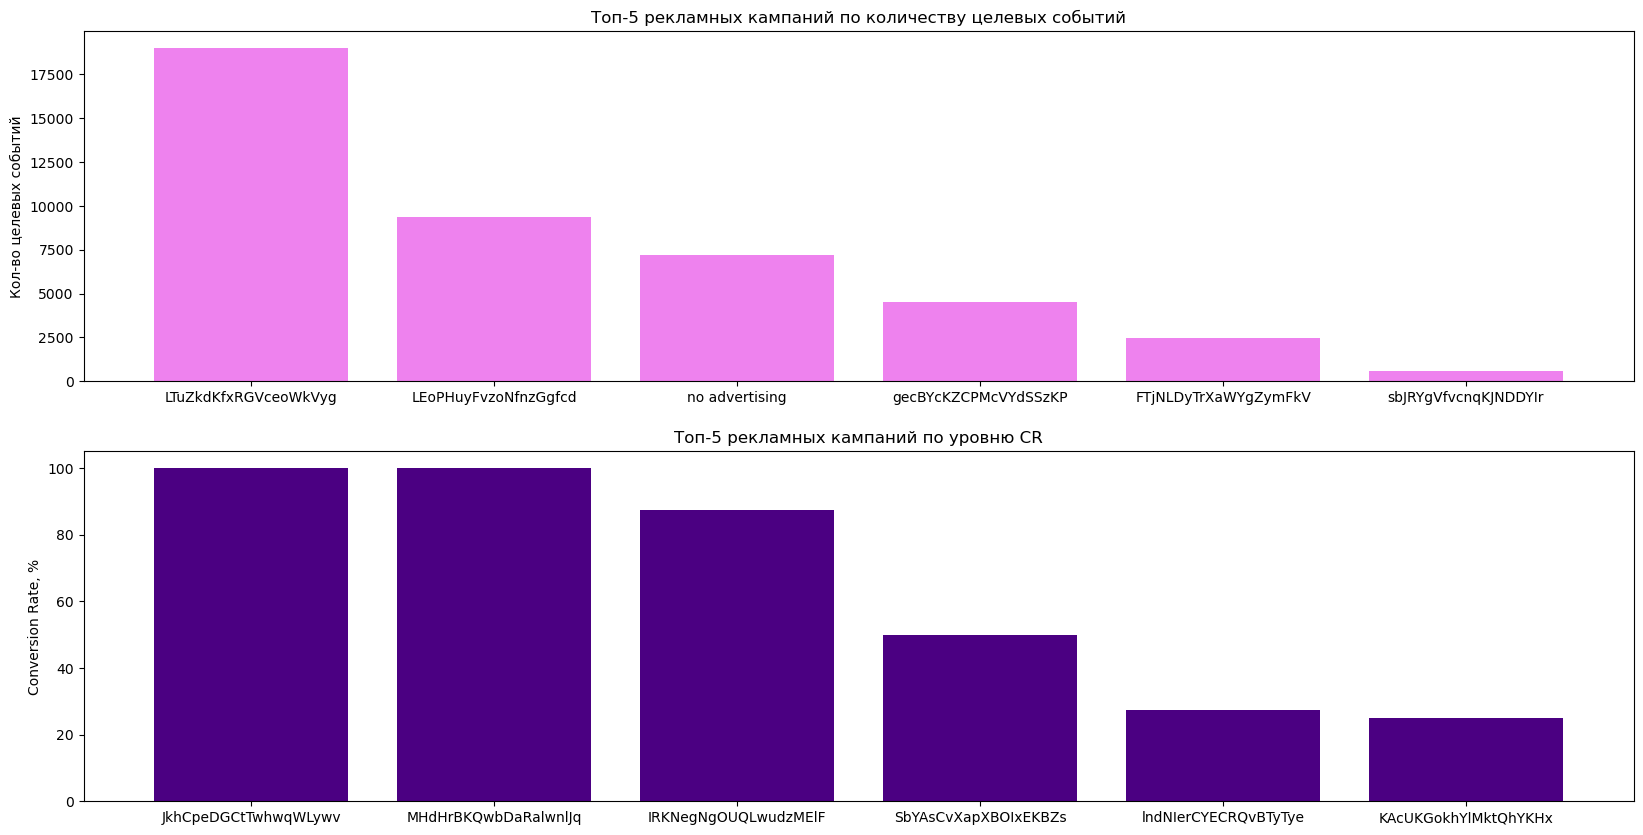

In [41]:
fig, axs = plt.subplots(nrows= 2 , ncols= 1, sharex='row', figsize=(20, 10))

axs[0].bar(df_camp['utm_campaign'][:6], df_camp['target'][:6], color=['violet'])
axs[0].set_title('Топ-5 рекламных кампаний по количеству целевых событий')
axs[0].set_ylabel('Кол-во целевых событий')

axs[1].bar(df_camp_cr['utm_campaign'][:6], df_camp_cr['conversion_rate'][:6], color=['indigo'])
axs[1].set_title('Топ-5 рекламных кампаний по уровню CR')
axs[1].set_ylabel('Conversion Rate, %')

plt.show()

### 6. Тип устройства

In [42]:
# Группировка типов устройств по количеству визитов 
vis_device = df_join.groupby(['device_category'], as_index=False)[['session_id']].count()
vis_device = vis_device.rename(columns={'session_id': 'quant'})

vis_device = vis_device.sort_values(by=['quant'], ascending=False).reset_index(drop=True)
vis_device['percent'] = round((vis_device['quant'] / df_join['session_id'].count() * 100), 1)
vis_device

,device_category,quant,percent
0,mobile,1474871,79.3
1,desktop,366863,19.7
2,tablet,18308,1.0


In [43]:
# Группировка типов устройств по количеству целевых действий
ta_device = df_join.groupby(['device_category'], as_index=False)[['target']].sum()
ta_device = ta_device.sort_values(by=['target'], ascending=False).reset_index(drop=True)

ta_device['percent'] = round((ta_device['target'] / df_join['target'].sum() * 100), 1)
ta_device['conversion_rate'] = round((ta_device['target'] / vis_device['quant'] * 100), 1)
ta_device

,device_category,target,percent,conversion_rate
0,mobile,38379,76.3,2.6
1,desktop,11513,22.9,3.1
2,tablet,422,0.8,2.3


**Вывод:** по количеству целевого трафика доминирует mobile, а по уровню CR - desktop.

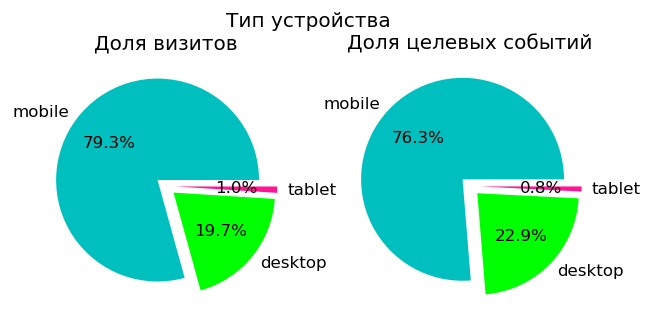

In [44]:
colors = {'mobile': 'c', 'desktop': 'lime', 'tablet': 'deeppink'}
fig, axes = plt.subplots(1, 2, figsize=(6,3),dpi=120)
plt.suptitle('Тип устройства')
explode = (0.1, 0.1, 0.1)

for ax, df, title in zip(axes, (vis_device, ta_device), ('Доля визитов', 'Доля целевых событий')):
    ax.pie(df.percent, labels=df.device_category, autopct = '%0.1f%%', explode=explode, colors=[colors[c] for c in df.device_category])
    ax.set_title(title)

### 7. Тип привлечения

In [45]:
# Группировка типов привлечения по количеству визитов
vis_medium = df_join.groupby(['utm_medium'], as_index=False)[['session_id']].count()
vis_medium = vis_medium.rename(columns={'session_id': 'quant'})
vis_medium = vis_medium.sort_values(by=['quant'], ascending=False).reset_index(drop=True)

vis_medium['q_percent'] = round((vis_medium['quant'] / df_join['session_id'].count() * 100), 1)
print(f'Топ-8 из {df_join.utm_medium.describe()[1]} типов привлечения по количеству визитов.')
vis_medium[:8]

Топ-8 из 56 типов привлечения по количеству визитов.


,utm_medium,quant,q_percent
0,banner,552272,29.7
1,cpc,434794,23.4
2,(none),300575,16.2
3,cpm,242083,13.0
4,referral,152050,8.2
5,organic,63034,3.4
6,email,29240,1.6
7,push,28035,1.5


In [46]:
# Группировка типов привлечения по количеству целевых событий
ta_medium = df_join.groupby(['utm_medium'], as_index=False)[['target']].sum()
ta_medium = ta_medium.sort_values(by=['target'], ascending=False).reset_index(drop=True)

ta_medium['t_percent'] = round((ta_medium['target'] / df_join['target'].sum() * 100), 1)
print(f'Топ-8 из {df_join.utm_medium.describe()[1]} типов привлечения по количеству целевых событий - target:')
ta_medium[:8]

Топ-8 из 56 типов привлечения по количеству целевых событий - target:


,utm_medium,target,t_percent
0,banner,15107,30.0
1,(none),10531,20.9
2,cpc,9529,18.9
3,referral,8181,16.3
4,cpm,2519,5.0
5,organic,2100,4.2
6,push,840,1.7
7,email,401,0.8


In [47]:
# Объединение сгруппированных датафреймов по количеству визитов и целевым событиям
df_medium = pd.merge(left=vis_medium, right=ta_medium, on=['utm_medium'], how='inner')

df_medium['conversion_rate'] = round((df_medium['target'] / df_medium['quant'] * 100), 1)

# Сортировка по количеству целевых событий
df_medium = df_medium.sort_values(by=['target'], ascending=False).reset_index(drop=True)
df_medium[:8]

,utm_medium,quant,q_percent,target,t_percent,conversion_rate
0,banner,552272,29.7,15107,30.0,2.7
1,(none),300575,16.2,10531,20.9,3.5
2,cpc,434794,23.4,9529,18.9,2.2
3,referral,152050,8.2,8181,16.3,5.4
4,cpm,242083,13.0,2519,5.0,1.0
5,organic,63034,3.4,2100,4.2,3.3
6,push,28035,1.5,840,1.7,3.0
7,email,29240,1.6,401,0.8,1.4


In [48]:
print(f'Органический трафик привлек {round(sum(df_medium["q_percent"].loc[[1,3,5]]),1)}% визитов и {round(sum(df_medium["t_percent"].loc[[1,3,5]]),1)}% целевых событий')
print(f'CR органического трафика в целевые события - {round(sum(df_medium["target"].loc[[1,3,5]])/sum(df_medium["quant"].loc[[1,3,5]])*100,1)}%')

Органический трафик привлек 27.8% визитов и 41.4% целевых событий
CR органического трафика в целевые события - 4.0%


In [49]:
# Сортировка по conversion_rate
df_medium_cr = df_medium.sort_values(by=['conversion_rate'], ascending=False).reset_index(drop=True)

print(f'Топ-8 из {df_join.utm_medium.describe()[1]} типов привлечений по уровню CR:')
df_medium_cr[:8]

Топ-8 из 56 типов привлечений по уровню CR:


,utm_medium,quant,q_percent,target,t_percent,conversion_rate
0,dom_click,1,0.0,1,0.0,100.0
1,link,57,0.0,17,0.0,29.8
2,landing,134,0.0,19,0.0,14.2
3,medium,8,0.0,1,0.0,12.5
4,social,9,0.0,1,0.0,11.1
5,CPM,40,0.0,3,0.0,7.5
6,sms,239,0.0,16,0.0,6.7
7,(not set),480,0.0,28,0.1,5.8


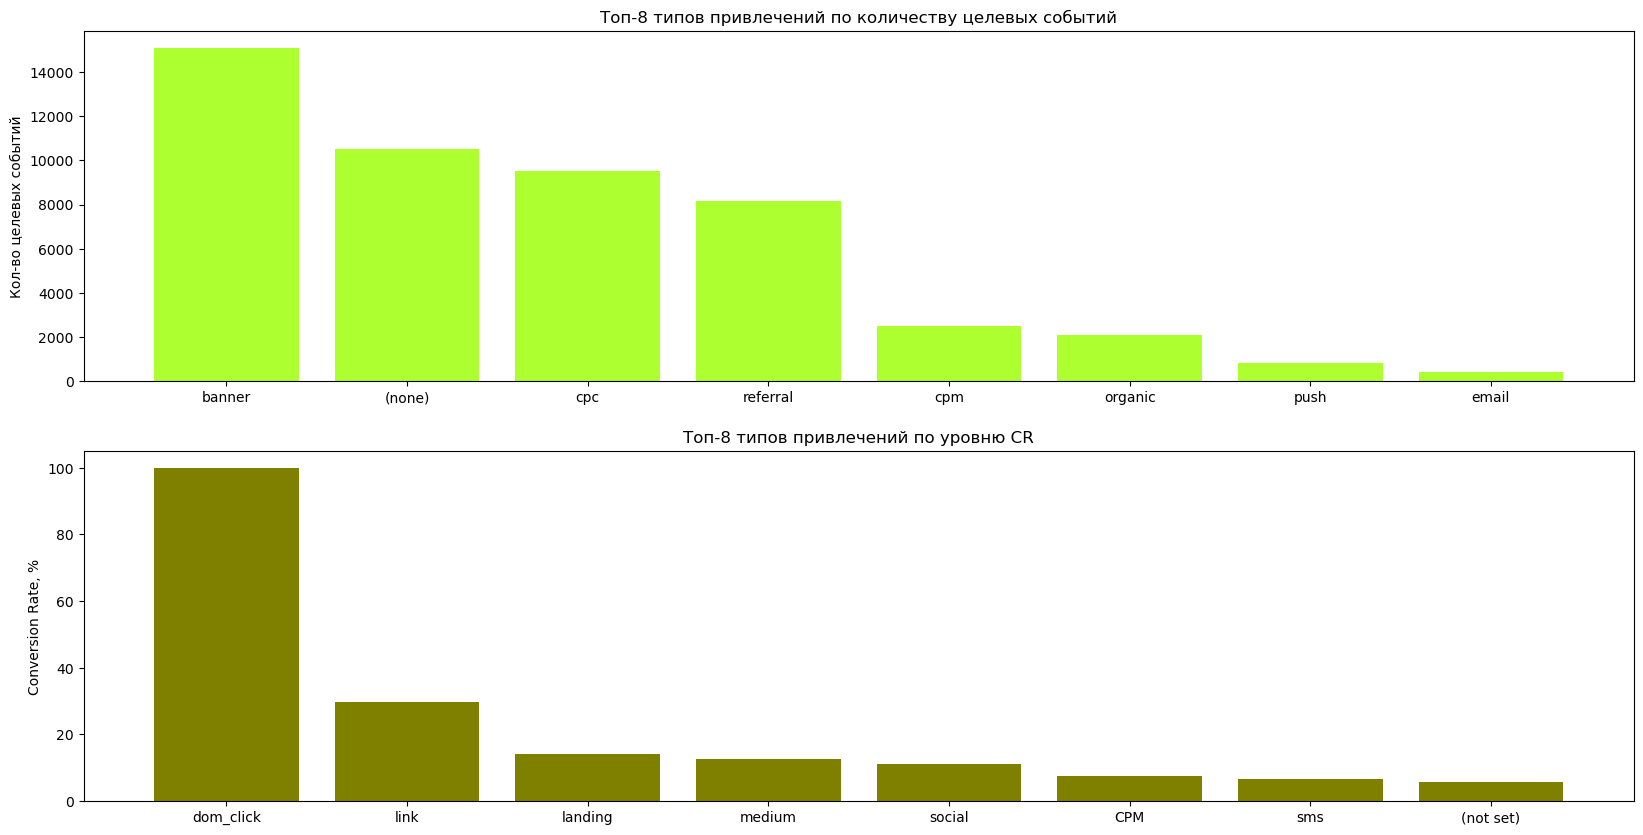

In [50]:
fig, axs = plt.subplots(nrows= 2 , ncols= 1, sharex='row', figsize=(20, 10))

axs[0].bar(df_medium['utm_medium'][:8], df_medium['target'][:8], color=['greenyellow'])
axs[0].set_title('Топ-8 типов привлечений по количеству целевых событий')
axs[0].set_ylabel('Кол-во целевых событий')

axs[1].bar(df_medium_cr['utm_medium'][:8], df_medium_cr['conversion_rate'][:8], color=['olive'])
axs[1].set_title('Топ-8 типов привлечений по уровню CR')
axs[1].set_ylabel('Conversion Rate, %')

plt.show()

In [51]:
# Группировка типов привлечения: органический/неорганический трафик по количеству визитов 
vis_traffic = df_join.groupby(['traffic_way'], as_index=False)[['session_id']].count()
vis_traffic = vis_traffic.rename(columns={'session_id': 'quant'})
vis_traffic = vis_traffic.sort_values(by=['quant'], ascending=False).reset_index(drop=True)

vis_traffic['percent'] = round((vis_traffic['quant'] / df_join['session_id'].count() * 100), 1)
vis_traffic

,traffic_way,quant,percent
0,paid,1344383,72.3
1,free,515659,27.7


In [52]:
# Группировка типов привлечения: органический/неорганический трафик по количеству целевых действий
ta_traffic = df_join.groupby(['traffic_way'], as_index=False)[['target']].sum()
ta_traffic = ta_traffic.sort_values(by=['target'], ascending=False).reset_index(drop=True)

ta_traffic['percent'] = round((ta_traffic['target'] / df_join['target'].sum() * 100), 1)
ta_traffic

,traffic_way,target,percent
0,paid,29502,58.6
1,free,20812,41.4


In [53]:
print(f'CR (Conversion Rate) типов трафика в целевые события:')
print(f'Платный трафик:      {ta_traffic.traffic_way[0]} = {round(ta_traffic.target[0] / vis_traffic.quant[0]*100,1)}%')
print(f'Органический трафик: {ta_traffic.traffic_way[1]} = {round(ta_traffic.target[1] / vis_traffic.quant[1]*100, 1)}%')

CR (Conversion Rate) типов трафика в целевые события:
Платный трафик:      paid = 2.2%
Органический трафик: free = 4.0%


**Вывод:** Платный трафик привлекает больше целевых событий, однако CR (Conversion Rate) в целевые события органического трафика выше.

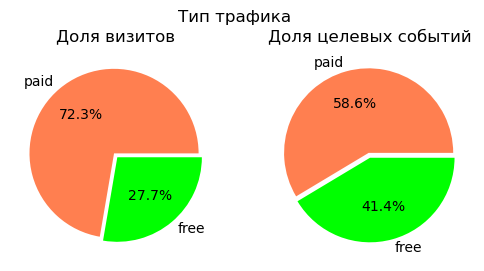

In [54]:
colors = {'paid': 'coral', 'free': 'lime'}
fig, axes = plt.subplots(1, 2, figsize=(6,3),dpi=100)
plt.suptitle('Тип трафика')
explode = (0.03, 0.03)

for ax, df, title in zip(axes, (vis_traffic, ta_traffic), ('Доля визитов', 'Доля целевых событий')):
    ax.pie(df.percent, labels=df.traffic_way, autopct = '%0.1f%%', explode=explode, colors=[colors[c] for c in df.traffic_way])
    ax.set_title(title)

### 8. Локация по странам

In [55]:
# Группировка стран по количеству визитов
vis_country = df_join.groupby(['geo_country'], as_index=False)[['session_id']].count()
vis_country = vis_country.rename(columns={'session_id': 'quant'})
vis_country = vis_country.sort_values(by=['quant'], ascending=False).reset_index(drop=True)

vis_country['q_percent'] = round((vis_country['quant'] / df_join['session_id'].count() * 100), 1)
print(f'Топ-5 из {df_join.geo_country.describe()[1]} стран по количеству визитов')
vis_country[:5]

Топ-5 из 166 стран по количеству визитов


,geo_country,quant,q_percent
0,Russia,1800565,96.8
1,United States,11784,0.6
2,Ukraine,9012,0.5
3,Ireland,4034,0.2
4,Belarus,3636,0.2


In [56]:
# Группировка стран по количеству целевых действий
ta_country = df_join.groupby(['geo_country'], as_index=False)[['target']].sum()
ta_country = ta_country.sort_values(by=['target'], ascending=False).reset_index(drop=True)

ta_country['t_percent'] = round((ta_country['target'] / df_join['target'].sum() * 100), 1)
print(f'Топ-5 из {df_join.geo_country.describe()[1]} стран по количеству целевых событий')
ta_country[:5]

Топ-5 из 166 стран по количеству целевых событий


,geo_country,target,t_percent
0,Russia,49156,97.7
1,Ukraine,199,0.4
2,Germany,78,0.2
3,United States,64,0.1
4,Belarus,59,0.1


In [57]:
# Объединение сгруппированных датафреймов по количеству визитов и целевым событиям
df_country = pd.merge(left=vis_country, right=ta_country, on=['geo_country'], how='inner')

df_country['conversion_rate'] = round((df_country['target'] / df_country['quant'] * 100), 1)

# Сортировка по количеству целевых событий
df_country = df_country.sort_values(by=['target'], ascending=False).reset_index(drop=True)
df_country[:5]

,geo_country,quant,q_percent,target,t_percent,conversion_rate
0,Russia,1800565,96.8,49156,97.7,2.7
1,Ukraine,9012,0.5,199,0.4,2.2
2,Germany,2232,0.1,78,0.2,3.5
3,United States,11784,0.6,64,0.1,0.5
4,Belarus,3636,0.2,59,0.1,1.6


In [58]:
# Сортировка по conversion_rate
df_country_cr = df_country.sort_values(by=['conversion_rate'], ascending=False).reset_index(drop=True)

print(f'Топ-5 из {df_join.geo_country.describe()[1]} стран по уровню CR:')
df_country_cr[:5]

Топ-5 из 166 стран по уровню CR:


,geo_country,quant,q_percent,target,t_percent,conversion_rate
0,Morocco,201,0.0,28,0.1,13.9
1,Albania,33,0.0,4,0.0,12.1
2,Slovenia,46,0.0,5,0.0,10.9
3,Philippines,27,0.0,2,0.0,7.4
4,Serbia,110,0.0,7,0.0,6.4


**Вывод:** Россия, как страна присутствия, доминирует по количеству трафика, но CR (Conversion Rate) у нее не самый высокий.

### 9. Локация по городам

In [59]:
# Группировка городов по количеству визитов
vis_city = df_join.groupby(['geo_city', 'geo_country'], as_index=False)[['session_id']].count()
vis_city = vis_city.rename(columns={'session_id': 'quant'})
vis_city = vis_city.sort_values(by=['quant'], ascending=False).reset_index(drop=True)

vis_city['q_percent'] = round((vis_city['quant'] / df_join['session_id'].count() * 100), 1)
print(f'Топ-10 из {df_join.geo_city.describe()[1]} городов по количеству визитов')
vis_city[:10]

Топ-10 из 2548 городов по количеству визитов


,geo_city,geo_country,quant,q_percent
0,Moscow,Russia,805329,43.3
1,Saint Petersburg,Russia,296788,16.0
2,(not set),Russia,70021,3.8
3,Yekaterinburg,Russia,35788,1.9
4,Krasnodar,Russia,32243,1.7
5,Kazan,Russia,29531,1.6
6,Samara,Russia,24992,1.3
7,Nizhny Novgorod,Russia,22227,1.2
8,Ufa,Russia,21679,1.2
9,Novosibirsk,Russia,21568,1.2


In [60]:
# Группировка городов по количеству целевых событий
ta_city = df_join.groupby(['geo_city', 'geo_country'], as_index=False)[['target']].sum()
ta_city = ta_city.sort_values(by=['target'], ascending=False).reset_index(drop=True)

ta_city['t_percent'] = round((ta_city['target'] / df_join['target'].sum() * 100), 1)
print(f'Топ-10 из {df_join.geo_city.describe()[1]} городов по количеству целевых событий')
ta_city[:10]

Топ-10 из 2548 городов по количеству целевых событий


,geo_city,geo_country,target,t_percent
0,Moscow,Russia,23629,47.0
1,Saint Petersburg,Russia,7113,14.1
2,(not set),Russia,1361,2.7
3,Kazan,Russia,1139,2.3
4,Krasnodar,Russia,1081,2.1
5,Yekaterinburg,Russia,887,1.8
6,Samara,Russia,727,1.4
7,Ufa,Russia,639,1.3
8,Nizhny Novgorod,Russia,559,1.1
9,Novosibirsk,Russia,509,1.0


In [61]:
# Объединение сгруппированных датафреймов по количеству визитов и целевым событиям
df_city = pd.merge(left=vis_city, right=ta_city, on=['geo_city', 'geo_country'], how='inner')

df_city['conversion_rate'] = round((df_city['target'] / df_city['quant'] * 100), 1)

# Сортировка по количеству целевых событий
df_city = df_city.sort_values(by=['target'], ascending=False).reset_index(drop=True)
df_city[:10]

,geo_city,geo_country,quant,q_percent,target,t_percent,conversion_rate
0,Moscow,Russia,805329,43.3,23629,47.0,2.9
1,Saint Petersburg,Russia,296788,16.0,7113,14.1,2.4
2,(not set),Russia,70021,3.8,1361,2.7,1.9
3,Kazan,Russia,29531,1.6,1139,2.3,3.9
4,Krasnodar,Russia,32243,1.7,1081,2.1,3.4
5,Yekaterinburg,Russia,35788,1.9,887,1.8,2.5
6,Samara,Russia,24992,1.3,727,1.4,2.9
7,Ufa,Russia,21679,1.2,639,1.3,2.9
8,Nizhny Novgorod,Russia,22227,1.2,559,1.1,2.5
9,Novosibirsk,Russia,21568,1.2,509,1.0,2.4


In [62]:
# Сортировка по conversion_rate
df_city_cr = df_city.sort_values(by=['conversion_rate'], ascending=False).reset_index(drop=True)

print(f'Топ-10 из {df_join.geo_city.describe()[1]} городов по уровню CR:')
df_city_cr[:10]

Топ-10 из 2548 городов по уровню CR:


,geo_city,geo_country,quant,q_percent,target,t_percent,conversion_rate
0,Brescia,Italy,1,0.0,1,0.0,100.0
1,Laguna Niguel,United States,1,0.0,1,0.0,100.0
2,Nipomo,United States,1,0.0,1,0.0,100.0
3,Nybro,Sweden,1,0.0,1,0.0,100.0
4,Beaver Falls,United States,1,0.0,1,0.0,100.0
5,Royan,France,1,0.0,1,0.0,100.0
6,Rostock,Germany,1,0.0,1,0.0,100.0
7,Qingdao,China,1,0.0,1,0.0,100.0
8,Guingamp,France,1,0.0,1,0.0,100.0
9,Middletown,United States,1,0.0,1,0.0,100.0


In [63]:
print(f'Топ-10 российских городов по уровню CR:')
df_rcity_cr = df_city_cr[df_city_cr["geo_country"] == "Russia"]
df_rcity_cr[:10]

Топ-10 российских городов по уровню CR:


,geo_city,geo_country,quant,q_percent,target,t_percent,conversion_rate
56,Enem,Russia,9,0.0,2,0.0,22.2
72,Marks,Russia,6,0.0,1,0.0,16.7
74,Birsk,Russia,6,0.0,1,0.0,16.7
78,Shuya,Russia,13,0.0,2,0.0,15.4
79,53425,Russia,20,0.0,3,0.0,15.0
84,Novaya Adygeya,Russia,7,0.0,1,0.0,14.3
86,Tarko-Sale,Russia,21,0.0,3,0.0,14.3
100,Pavlovo,Russia,63,0.0,7,0.0,11.1
121,Troedobelikovskiy,Russia,35,0.0,3,0.0,8.6
122,Kinel,Russia,12,0.0,1,0.0,8.3


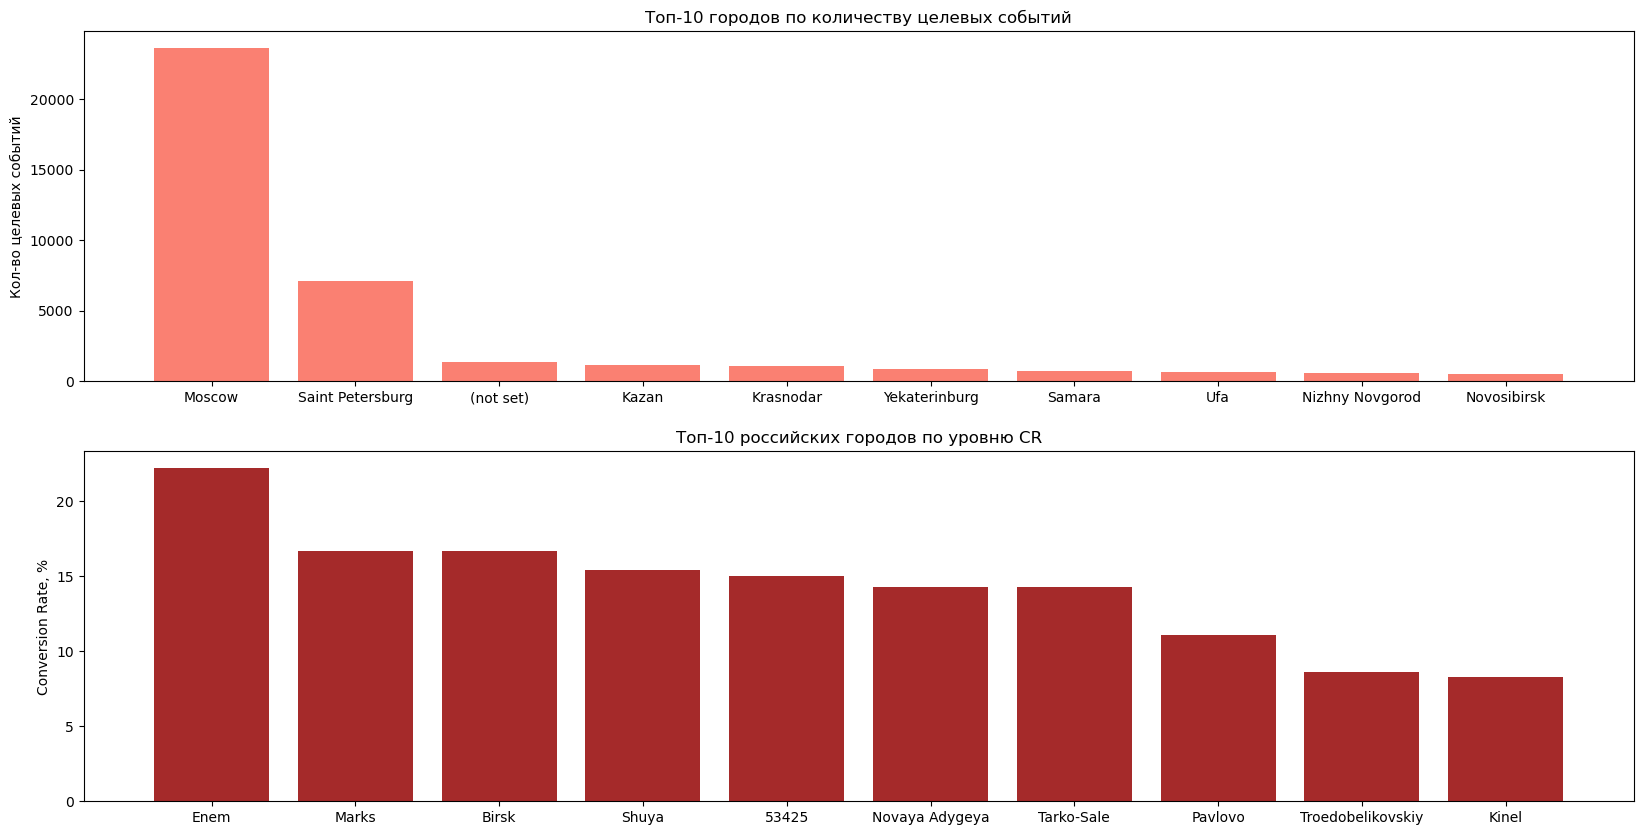

In [64]:
fig, axs = plt.subplots(nrows= 2 , ncols= 1, sharex='row', figsize=(20, 10))

axs[0].bar(df_city['geo_city'][:10], df_city['target'][:10], color=['salmon'])
axs[0].set_title('Топ-10 городов по количеству целевых событий')
axs[0].set_ylabel('Кол-во целевых событий')

axs[1].bar(df_rcity_cr['geo_city'][:10], df_rcity_cr['conversion_rate'][:10], color=['brown'])
axs[1].set_title('Топ-10 российских городов по уровню CR')
axs[1].set_ylabel('Conversion Rate, %')

plt.show()

In [65]:
# Группировка городов присутствия по количеству визитов
vis_city_pres = df_join.groupby(['city_of_present'], as_index=False)[['session_id']].count()
vis_city_pres = vis_city_pres.rename(columns={'session_id': 'quant'})
vis_city_pres = vis_city_pres.sort_values(by=['quant'], ascending=False).reset_index(drop=True)

vis_city_pres['percent'] = round((vis_city_pres['quant'] / df_join['session_id'].count() * 100), 1)
vis_city_pres

,city_of_present,quant,percent
0,present,1198013,64.4
1,other,662029,35.6


In [66]:
# Группировка городов присутствия по целевым событиям
ta_city_pres = df_join.groupby(['city_of_present'], as_index=False)[['target']].sum()
ta_city_pres = ta_city_pres.sort_values(by=['target'], ascending=False).reset_index(drop=True)

ta_city_pres['percent'] = round((ta_city_pres['target'] / df_join['target'].sum() * 100), 1)
ta_city_pres

,city_of_present,target,percent
0,present,33520,66.6
1,other,16794,33.4


In [67]:
print(f'CR (Conversion Rate) трафика из городов присутствия в целевые события:')
print(f'{ta_city_pres.city_of_present[0]} = {round(ta_city_pres.target[0] / vis_city_pres.quant[0]*100,1)}%')
print(f'{ta_city_pres.city_of_present[1]} = {round(ta_city_pres.target[1] / vis_city_pres.quant[1]*100, 1)}%')

CR (Conversion Rate) трафика из городов присутствия в целевые события:
present = 2.8%
other = 2.5%


**Вывод:** Целевой трафик из городов присутствия на треть выше трафика из других регионов, но CR в целевые события из городов присутствия незначительно превышает CR из других регионов.

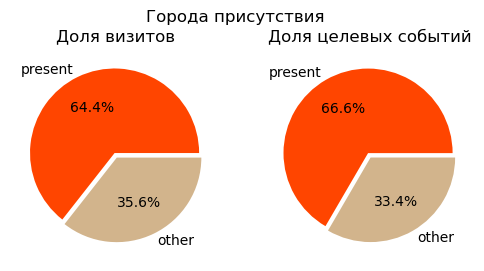

In [68]:
colors = {'present': 'orangered', 'other': 'tan'}
fig, axes = plt.subplots(1, 2, figsize=(6,3),dpi=100)
plt.suptitle('Города присутствия')
explode = (0.03, 0.03)

for ax, df, title in zip(axes, (vis_city_pres, ta_city_pres), ('Доля визитов', 'Доля целевых событий')):
    ax.pie(df.percent, labels=df.city_of_present, autopct = '%0.1f%%', explode=explode, colors=[colors[c] for c in df.city_of_present])
    ax.set_title(title)

### 10. Автомобили

In [69]:
df_h_auto = df_h_clean[['session_id', 'target_action', 'auto_name', 'auto_model']]
df_h_auto.head()

,session_id,target_action,auto_name,auto_model
0,5639623078712724064.1640254056.1640254056,0,other,other
1,7750352294969115059.1640271109.1640271109,0,other,other
2,885342191847998240.1640235807.1640235807,0,volkswagen,polo
3,142526202120934167.1640211014.1640211014,0,other,other
4,3450086108837475701.1640265078.1640265078,0,mercedes-benz,cla-klasse


In [70]:
# Группировка автомобилей по количеству событий
vis_auto = df_h_auto.groupby(['auto_name', 'auto_model'], as_index=False)[['session_id']].count()
vis_auto = vis_auto.rename(columns={'session_id': 'quant'})
vis_auto = vis_auto.sort_values(by=['quant'], ascending=False).reset_index(drop=True)

vis_auto['q_percent'] = round((vis_auto['quant'] / df_h_auto['session_id'].count() * 100), 1)

print(f'Топ-10 автомобилей по количеству событий')
vis_auto[:11]

Топ-10 автомобилей по количеству событий


,auto_name,auto_model,quant,q_percent
0,other,other,12198829,77.6
1,skoda,rapid,442579,2.8
2,lada-vaz,vesta,403994,2.6
3,volkswagen,polo,318146,2.0
4,skoda,karoq,194291,1.2
5,mercedes-benz,e-klasse,178475,1.1
6,nissan,qashqai,153169,1.0
7,kia,rio,90299,0.6
8,nissan,x-trail,85595,0.5
9,skoda,octavia,77197,0.5


In [71]:
# Группировка автомобилей по количеству целевых событий
ta_auto = df_h_auto.groupby(['auto_name', 'auto_model'], as_index=False)[['target_action']].sum()
ta_auto = ta_auto.sort_values(by=['target_action'], ascending=False).reset_index(drop=True)

ta_auto['t_percent'] = round((ta_auto['target_action'] / df_h_auto['target_action'].sum() * 100), 1)

print(f'Топ-20 автомобилей по количеству целевых событий')
ta_auto[:20]

Топ-20 автомобилей по количеству целевых событий


,auto_name,auto_model,target_action,t_percent
0,other,other,72906,69.5
1,skoda,rapid,6030,5.7
2,lada-vaz,vesta,5356,5.1
3,volkswagen,polo,4634,4.4
4,kia,rio,1438,1.4
5,skoda,karoq,1305,1.2
6,mercedes-benz,e-klasse,1245,1.2
7,toyota,camry,1145,1.1
8,renault,logan,893,0.9
9,nissan,qashqai,891,0.8


In [72]:
# Объединение сгруппированных датафреймов по количеству визитов и целевым событиям
df_auto = pd.merge(left=vis_auto, right=ta_auto, on=['auto_name', 'auto_model'], how='inner')

# Сортировка по target_action
df_auto = df_auto.sort_values(by=['target_action'], ascending=False).reset_index(drop=True)
df_auto['conversion_rate'] = round((df_auto['target_action'] / df_auto['quant'] * 100), 1)

df_auto[:11]

,auto_name,auto_model,quant,q_percent,target_action,t_percent,conversion_rate
0,other,other,12198829,77.6,72906,69.5,0.6
1,skoda,rapid,442579,2.8,6030,5.7,1.4
2,lada-vaz,vesta,403994,2.6,5356,5.1,1.3
3,volkswagen,polo,318146,2.0,4634,4.4,1.5
4,kia,rio,90299,0.6,1438,1.4,1.6
5,skoda,karoq,194291,1.2,1305,1.2,0.7
6,mercedes-benz,e-klasse,178475,1.1,1245,1.2,0.7
7,toyota,camry,73243,0.5,1145,1.1,1.6
8,renault,logan,72121,0.5,893,0.9,1.2
9,nissan,qashqai,153169,1.0,891,0.8,0.6


In [73]:
# Сортировка по conversion_rate
df_auto_cr = df_auto.sort_values(by=['conversion_rate'], ascending=False).reset_index(drop=True)
print(f'Топ автомобилей по уровню CR')
df_auto_cr[:30]

Топ автомобилей по уровню CR


,auto_name,auto_model,quant,q_percent,target_action,t_percent,conversion_rate
0,toyota,auris,2,0.0,2,0.0,100.0
1,sberauto.com,autosubscribe&referrer=af_tranid=yeecoe-3r622k...,9,0.0,7,0.0,77.8
2,macan,other,3,0.0,2,0.0,66.7
3,sberauto.com,autosubscribe&referrer=af_tranid=lywyrxs4as3kf...,5,0.0,3,0.0,60.0
4,sberauto.com,autosubscribe&referrer=af_tranid=9ouahk6mcib9s...,5,0.0,3,0.0,60.0
5,ceed,other,5,0.0,2,0.0,40.0
6,honda,cr-v,7,0.0,2,0.0,28.6
7,x1,other,7,0.0,2,0.0,28.6
8,sberauto.com,autosubscribe&referrer=af_tranid=0qqowm3pozeyf...,7,0.0,2,0.0,28.6
9,alfa-romeo,other,8,0.0,2,0.0,25.0


In [74]:
# Размерность сгруппированного по авто датафрейма
df_auto_cr.shape

(5669, 7)

In [75]:
# Очистим столбец с моделью авто от лишней информации
df_auto_cr_clean = df_auto_cr[(df_auto_cr.auto_name != 'sberauto.com') & (df_auto_cr.auto_name != 'zen.yandex.com')]

df_auto_cr_clean[:10]

,auto_name,auto_model,quant,q_percent,target_action,t_percent,conversion_rate
0,toyota,auris,2,0.0,2,0.0,100.0
2,macan,other,3,0.0,2,0.0,66.7
5,ceed,other,5,0.0,2,0.0,40.0
6,honda,cr-v,7,0.0,2,0.0,28.6
7,x1,other,7,0.0,2,0.0,28.6
9,alfa-romeo,other,8,0.0,2,0.0,25.0
10,audi,a6,9,0.0,2,0.0,22.2
12,nexia,other,10,0.0,2,0.0,20.0
13,g-klasse,sale,16,0.0,3,0.0,18.8
14,defender,other,13,0.0,2,0.0,15.4


In [76]:
# Размерность очищенного датафрейма с авто
df_auto_cr_clean.shape

(845, 7)

In [77]:
print(f'Топ автомобилей по уровню CR')
df_auto_cr_clean[:20]

Топ автомобилей по уровню CR


,auto_name,auto_model,quant,q_percent,target_action,t_percent,conversion_rate
0,toyota,auris,2,0.0,2,0.0,100.0
2,macan,other,3,0.0,2,0.0,66.7
5,ceed,other,5,0.0,2,0.0,40.0
6,honda,cr-v,7,0.0,2,0.0,28.6
7,x1,other,7,0.0,2,0.0,28.6
9,alfa-romeo,other,8,0.0,2,0.0,25.0
10,audi,a6,9,0.0,2,0.0,22.2
12,nexia,other,10,0.0,2,0.0,20.0
13,g-klasse,sale,16,0.0,3,0.0,18.8
14,defender,other,13,0.0,2,0.0,15.4


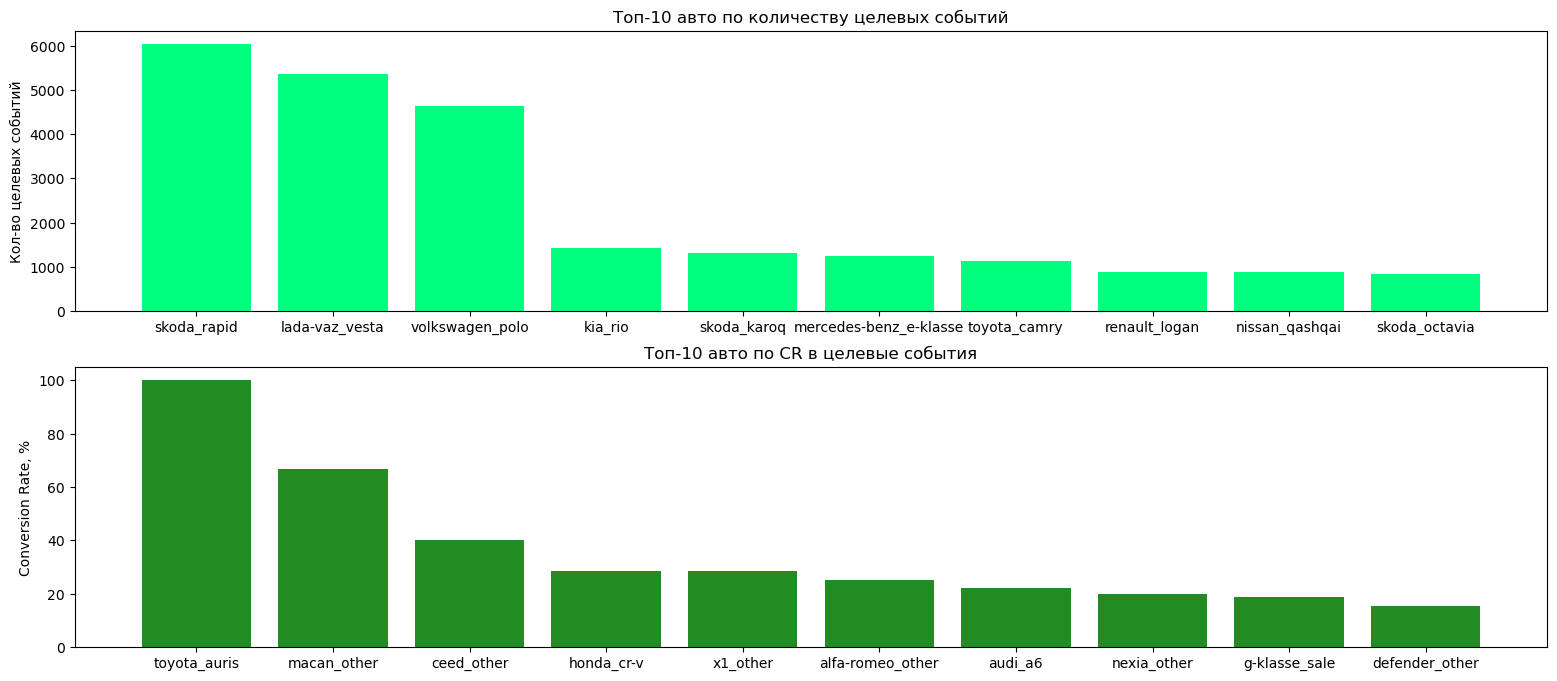

In [79]:
fig, axs = plt.subplots(nrows= 2 , ncols= 1, sharex='row', figsize=(19, 8))

axs[0].bar((df_auto['auto_name']+'_'+df_auto['auto_model'])[1:11], df_auto['target_action'][1:11], color=['springgreen'])
axs[0].set_title('Топ-10 авто по количеству целевых событий')
axs[0].set_ylabel('Кол-во целевых событий')

axs[1].bar((df_auto_cr_clean['auto_name']+'_'+df_auto_cr_clean['auto_model'])[:10], df_auto_cr_clean['conversion_rate'][:10], color=['forestgreen'])
axs[1].set_title('Топ-10 авто по CR в целевые события')
axs[1].set_ylabel('Conversion Rate, %')

plt.show()

### 11. Корреляция численных признаков

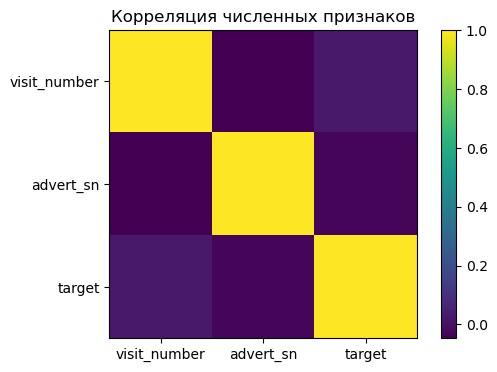

In [80]:
plt.figure(figsize=(6, 4))

columns = df_join.corr().columns.tolist()
plt.imshow(df_join.corr())

plt.title("Корреляция численных признаков")
plt.xticks(range(0, len(columns)), columns)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show()

Матрица корреляций по имеющимся численным признакам не позволяет сделать существенных выводов о зависимостях в датафрейме.

### Общие выводы для продуктовой команды

#### 1. Из каких источников / кампаний / устройств / локаций идёт самый целевой трафик (и с точки зрения объёма трафика, и с точки зрения CR)?

**1.1 Топ каналов привлечения**

In [81]:
print('По объему целевого трафика')
df_source[['utm_source', 't_percent', 'conversion_rate']][:7]

По объему целевого трафика


,utm_source,t_percent,conversion_rate
0,ZpYIoDJMcFzVoPFsHGJL,31.8,2.8
1,fDLlAcSmythWSCVMvqvL,20.9,3.5
2,kjsLglQLzykiRbcDiGcD,12.5,2.4
3,bByPQxmDaMXgpHeypKSM,11.0,5.4
4,BHcvLfOaCWvWTykYqHVe,7.7,3.3
5,MvfHsxITijuriZxsqZqt,4.5,1.2
6,aXQzDWsJuGXeBXexNHjc,3.6,5.9


In [82]:
print('По CR')
df_source_cr[['utm_source', 't_percent', 'conversion_rate']][:7]

По CR


,utm_source,t_percent,conversion_rate
0,YpBKcihLLfFjWuxOLfvW,0.0,100.0
1,fJCYsujgSxIHFbOmgDdN,0.0,87.5
2,XzfzEBYZWgSDtJNXOadn,0.0,50.0
3,CqeIpFwJscTsZoYXdHsP,0.0,50.0
4,yxJKymlSGVuKIPTxbysx,0.0,33.3
5,LIWKeifdTCbuNeniIUqm,0.0,29.8
6,JcVHXwVSrnfIuOMMEkrJ,0.0,25.0


**1.2 Топ типов привлечения**

In [83]:
print('По объему целевого трафика')
df_medium[['utm_medium', 't_percent', 'conversion_rate']][:7]

По объему целевого трафика


,utm_medium,t_percent,conversion_rate
0,banner,30.0,2.7
1,(none),20.9,3.5
2,cpc,18.9,2.2
3,referral,16.3,5.4
4,cpm,5.0,1.0
5,organic,4.2,3.3
6,push,1.7,3.0


In [84]:
print('По CR')
df_medium_cr[['utm_medium', 't_percent', 'conversion_rate']][:7]

По CR


,utm_medium,t_percent,conversion_rate
0,dom_click,0.0,100.0
1,link,0.0,29.8
2,landing,0.0,14.2
3,medium,0.0,12.5
4,social,0.0,11.1
5,CPM,0.0,7.5
6,sms,0.0,6.7


In [87]:
print(f'Объем целевых событий по типам трафика:')
ta_traffic[['traffic_way', 'percent']]

Объем целевых событий по типам трафика:


,traffic_way,percent
0,paid,58.6
1,free,41.4


In [88]:
print(f'CR (Conversion Rate) типов трафика в целевые события:')
print(f'Платный трафик:      {ta_traffic.traffic_way[0]} = {round(ta_traffic.target[0] / vis_traffic.quant[0]*100,1)}%')
print(f'Органический трафик: {ta_traffic.traffic_way[1]} = {round(ta_traffic.target[1] / vis_traffic.quant[1]*100, 1)}%')

CR (Conversion Rate) типов трафика в целевые события:
Платный трафик:      paid = 2.2%
Органический трафик: free = 4.0%


Платный трафик привлекает больше целевых событий, однако CR в целевые события органического трафика выше.

**1.3 Топ рекламных кампаний**

In [89]:
print('По объему целевого трафика')
df_camp[['utm_campaign', 't_percent', 'conversion_rate']][:7]

По объему целевого трафика


,utm_campaign,t_percent,conversion_rate
0,LTuZkdKfxRGVceoWkVyg,37.8,4.1
1,LEoPHuyFvzoNfnzGgfcd,18.6,2.9
2,no advertising,14.3,3.3
3,gecBYcKZCPMcVYdSSzKP,9.0,3.4
4,FTjNLDyTrXaWYgZymFkV,4.9,1.0
5,sbJRYgVfvcnqKJNDDYIr,1.1,2.8
6,XHNUiSKKGTEpSAlaVMFQ,0.8,1.6


In [90]:
print('По CR')
df_camp_cr[['utm_campaign', 't_percent', 'conversion_rate']][:7]

По CR


,utm_campaign,t_percent,conversion_rate
0,JkhCpeDGCtTwhwqWLywv,0.0,100.0
1,MHdHrBKQwbDaRalwnlJq,0.0,100.0
2,IRKNegNgOUQLwudzMElF,0.0,87.5
3,SbYAsCvXapXBOIxEKBZs,0.0,50.0
4,lndNIerCYECRQvBTyTye,0.0,27.4
5,KAcUKGokhYlMktQhYKHx,0.0,25.0
6,vZqcBrFwxYPoYzJyhYGI,0.0,22.2


**1.4 Типы устройства**

In [91]:
ta_device[['device_category', 'percent', 'conversion_rate']]

,device_category,percent,conversion_rate
0,mobile,76.3,2.6
1,desktop,22.9,3.1
2,tablet,0.8,2.3


По количеству целевого трафика доминирует mobile, а по уровню CR - desktop.

**1.5 Топ стран**

In [92]:
print('По объему целевого трафика')
df_country[['geo_country', 't_percent', 'conversion_rate']][:5]

По объему целевого трафика


,geo_country,t_percent,conversion_rate
0,Russia,97.7,2.7
1,Ukraine,0.4,2.2
2,Germany,0.2,3.5
3,United States,0.1,0.5
4,Belarus,0.1,1.6


In [93]:
print('По CR')
df_country_cr[['geo_country', 't_percent', 'conversion_rate']][:5]

По CR


,geo_country,t_percent,conversion_rate
0,Morocco,0.1,13.9
1,Albania,0.0,12.1
2,Slovenia,0.0,10.9
3,Philippines,0.0,7.4
4,Serbia,0.0,6.4


Россия, как страна присутствия, доминирует по количеству трафика, но CR (Conversion Rate) у нее не самый высокий.

**1.6 Топ городов**

In [94]:
print('По объему целевого трафика')
df_city[['geo_city', 'geo_country', 't_percent', 'conversion_rate']][:10]

По объему целевого трафика


,geo_city,geo_country,t_percent,conversion_rate
0,Moscow,Russia,47.0,2.9
1,Saint Petersburg,Russia,14.1,2.4
2,(not set),Russia,2.7,1.9
3,Kazan,Russia,2.3,3.9
4,Krasnodar,Russia,2.1,3.4
5,Yekaterinburg,Russia,1.8,2.5
6,Samara,Russia,1.4,2.9
7,Ufa,Russia,1.3,2.9
8,Nizhny Novgorod,Russia,1.1,2.5
9,Novosibirsk,Russia,1.0,2.4


In [95]:
print('По CR')
df_city_cr[['geo_city', 'geo_country', 't_percent', 'conversion_rate']][:10]

По CR


,geo_city,geo_country,t_percent,conversion_rate
0,Brescia,Italy,0.0,100.0
1,Laguna Niguel,United States,0.0,100.0
2,Nipomo,United States,0.0,100.0
3,Nybro,Sweden,0.0,100.0
4,Beaver Falls,United States,0.0,100.0
5,Royan,France,0.0,100.0
6,Rostock,Germany,0.0,100.0
7,Qingdao,China,0.0,100.0
8,Guingamp,France,0.0,100.0
9,Middletown,United States,0.0,100.0


#### 2. Какие авто пользуются наибольшим спросом? У каких авто самый лучший показатель CR (Conversion Rate) в целевые события?

In [96]:
print('Топ авто, которые пользуются наибольшим спросом (с наибольшим целевым трафиком)')
df_auto[['auto_name', 'auto_model', 't_percent', 'conversion_rate']][:11]

Топ авто, которые пользуются наибольшим спросом (с наибольшим целевым трафиком)


,auto_name,auto_model,t_percent,conversion_rate
0,other,other,69.5,0.6
1,skoda,rapid,5.7,1.4
2,lada-vaz,vesta,5.1,1.3
3,volkswagen,polo,4.4,1.5
4,kia,rio,1.4,1.6
5,skoda,karoq,1.2,0.7
6,mercedes-benz,e-klasse,1.2,0.7
7,toyota,camry,1.1,1.6
8,renault,logan,0.9,1.2
9,nissan,qashqai,0.8,0.6


In [97]:
print('Топ авто по CR)')
df_auto_cr_clean[['auto_name', 'auto_model', 't_percent', 'conversion_rate']][:11]

Топ авто по CR)


,auto_name,auto_model,t_percent,conversion_rate
0,toyota,auris,0.0,100.0
2,macan,other,0.0,66.7
5,ceed,other,0.0,40.0
6,honda,cr-v,0.0,28.6
7,x1,other,0.0,28.6
9,alfa-romeo,other,0.0,25.0
10,audi,a6,0.0,22.2
12,nexia,other,0.0,20.0
13,g-klasse,sale,0.0,18.8
14,defender,other,0.0,15.4


#### 3. Стоит ли нам увеличивать своё присутствие в соцсетях и давать там больше рекламы?

In [98]:
print(f'Реклама в соцсетях привлекла {ta_advert.percent[1]}% целевых событий.')
print(f'CR рекламы в соцсетях в целевые события - {round(ta_advert.target[1] / vis_advert.quant[1] *100, 1)}%')

Реклама в соцсетях привлекла 8.0% целевых событий.
CR рекламы в соцсетях в целевые события - 1.5%


Увеличивать присутствие в соцсетях и давать больше рекламы не стоит.